In [1]:
import os
import time
import collections

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
from utils.utilities import fetch_data, live_plot
from utils.td3 import Agent
from utils.envs import TradingEnv1, TradingEnv4, TradingEnv5, TradingEnv6, TradingEnv7, TradingEnv9

In [4]:
import warnings

warnings.simplefilter('ignore')

In [5]:
%matplotlib inline

---

In [6]:
env_name = 'TradingEnv9'
db_name = './data/HistoricalPriceData.db'

seed = 42

In [7]:
torch.manual_seed(seed)
np.random.seed(seed)

##### Fetch the data

In [8]:
data = fetch_data(db_name)

In [9]:
# Don't include 2020 shock
for tick in data:
    data[tick] = data[tick][
        data[tick]['date'] <= pd.to_datetime('2020-02-01')
    ]

In [10]:
size = 520 # About two years
idx = np.random.randint(0, len(data['fb'])-size)

for t in data:
    data[t] = data[t].iloc[idx: idx+size]
    data[t].reset_index(drop=True, inplace=True)

In [11]:
print(idx)

1126


##### Initialize environment and set seeds

In [12]:
env = eval(f'{env_name}(data)')
env.seed(seed)

In [13]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Create folder in which trained models will be saved

In [14]:
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./models/all_td3'):
    os.makedirs('./models/all_td3')

In [15]:
file_name = f'TD3_{env_name}_pred_{seed}'
print(file_name)

TD3_TradingEnv9_pred_42


##### Initialize agent parameters

In [16]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.15

##### Initialize agent

In [18]:
agent_state_dim = env.observation_space.shape[0] * (env.observation_space.shape[1]+1)

In [19]:
agent = Agent(
    agent_state_dim, 
    action_dim, 
    max_action,
    eta=lr,
)


---

##### Build predictor model

In [20]:
class Model(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(Model, self).__init__()
        
        h1, h2 = 200, 100
        
        self.layer_1 = nn.Linear(input_dim, h1) 
        self.layer_2 = nn.Linear(h1, h2) 
        self.layer_3 = nn.Linear(h2, output_dim)
        
    def forward(self, X):
        
        X = F.relu(self.layer_1(X))
        X = F.relu(self.layer_2(X))
        X = self.layer_3(X)
        
        return X
        

In [21]:
class Predictor:
    
    def __init__(self, input_dim, output_dim, eta=0.01):
                
        self.model = Model(input_dim, output_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=eta)
        
        self.X_full = []
        self.y_full = []
    
    def commit(self, X, y):
        
        self.X_full.append(X)
        self.y_full.append(y)

    def train(self, epochs=10, batch_size=100):
        
        idx = np.random.randint(0, len(self.X_full), size=batch_size)
        
        X, y = [], []
        for i in idx:
            X.append(self.X_full[i][:-1, :-2].flatten().copy())
            y.append(self.y_full[i][:-1, 5].copy())

        X = torch.stack([torch.FloatTensor(x_) for x_ in X])
        y = torch.stack([torch.FloatTensor(y_) for y_ in y])
            
        for i in np.arange(epochs):
            
            loss = F.mse_loss(self.model(X), y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return self
            
    def predict_many(self, X):
        
        X_new = []
        
        for x in X:
            
            _x = torch.FloatTensor(
                x[:-1, :-2].flatten().copy()
            )
            
            y = self.model(_x)
            _y = np.c_[x, [*y.data, 0]]
            
            X_new.append(_y)
            
        return np.array(X_new)
    
    def predict(self, X):
        
        _X = torch.FloatTensor(
            X[:-1, :-2].flatten().copy()
        )

        y = self.model(_X)

        return np.c_[X, [*y.data, 0]].astype(np.float64)


In [22]:
features = ['close', 'volume', 'ma_30', 'ma_5', 'volatil', 'diff', 'diff_ma_5', 'exp', 'pps']

In [23]:
input_dim = 35 # obs[:-1, :-2].flatten()
output_dim = 5 # new_obs[:-1, 5]

In [24]:
predictor = Predictor(input_dim, output_dim)

---

##### Initialize training variables 

In [25]:
#agent.load(file_name, './models')

In [26]:
starting_step = 3e4 # Number of random steps at start

episodes = 1e3 # Number of episodes to train on
total_steps = 0
training = False
report = 50

In [27]:
positions = env.positions
print(positions)

('fb', 'amzn', 'aapl', 'msft', 'goog', '_out')


In [28]:
reward_trace = collections.defaultdict(list)

##### Training:

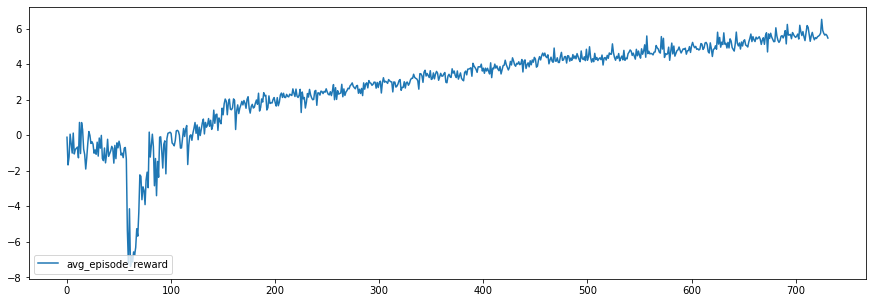

In [ ]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
        
    
    
    while not done:    
        
        agent_obs = predictor.predict(obs)
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(agent_obs)
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        action_fmt = env.format_action(positions, action)
                
        new_obs, reward, done, info = env.step(action_fmt)
        
        episode_reward.append(reward)
        predictor.commit(obs, new_obs)        
        
        agent_new_obs = predictor.predict(new_obs)
        agent.replay_buffer.add((agent_obs, agent_new_obs, action, reward, int(done)))
                
        obs = new_obs
        steps += 1
        total_steps += 1
        

        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    predictor.train(batch_size)
    
    reward_trace['net_worth_diff'].append(sum(np.array(env.net_worth)-np.array(env.net_worth_long)))
    reward_trace['avg_episode_reward'].append(np.mean(episode_reward))
    reward_trace['sum_episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace, trace='avg')                                                      ###
    plt.show()                                                                                     ###
    
    if episode % report == 0:
#        clear_output(wait=True)                                                                   ###
        
        print('Episode:', episode)
        print('Average net worth diff', np.mean(reward_trace['net_worth_diff'][-report:]))
        print('Average score:', np.mean(reward_trace['avg_episode_reward'][-report:]))
        print('Exploration noise:', reward_trace['exploration_noise'][-1])
        print('Training:', training)
        time.sleep(1)
        
        agent.save(
            f'{file_name}_{int(episode)}', 
            './models/all_td3',
        )
        

TD3_TradingEnv9_pred_42

In [ ]:
total_steps

In [ ]:
episode

In [ ]:
expl_noise

---

##### Plot reward trace

In [ ]:
nwd = pd.Series(reward_trace['net_worth_diff'])
nwd = nwd.rolling(window=report, center=True, min_periods=1).mean()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.7)
plt.plot(nwd, 'b')
plt.axvline(950, c='r')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['avg_episode_reward'], 'b')
plt.axvline(950, c='r')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['sum_episode_reward'], 'b')
plt.axvline(950, c='r')

plt.show()

##### Save only model from selected point in training history

In [ ]:
idx = 950

agent.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)

agent.save(
    file_name, 
    './models',
)

for item in os.listdir('./models/all_td3'):
    if file_name in str(item):
        os.remove(os.path.join('./models/all_td3', item))

In [ ]:
file_name